In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import glasbey
import pickle
import time
from pathlib import Path
import distro

%load_ext watermark

In [ ]:
# old one '1.8.1+cu111'
torch.__version__

'2.5.0+cu124'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.train_stuff import *
from text_embeddings_src.eval_functions import KNNEval, MTEBEval
from text_embeddings_src.models import FineTunedHFModelWrapper
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2025-03-13 15:57:01CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.31.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

tqdm               : 4.66.4
matplotlib         : 3.9.2
distro             : 1.9.0
glasbey            : 0.2.1
numpy              : 1.26.4
transformers       : 4.45.2
torch              : 2.5.0
jupyter_black      : 0.4.0
text_embeddings_src: 0.0.0
pandas             : 2.2.3
black              : 24.10.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import ICLR dataset

In [ ]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 270 ms, sys: 60.9 ms, total: 331 ms
Wall time: 355 ms


In [ ]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [ ]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [ ]:
iclr2024.abstract[labels_iclr != "unlabeled"].to_list()
type(labels_iclr)

numpy.ndarray

# Benchmarks

## Tasks

In [ ]:
mteb_tasks = [
    "ArxivClusteringP2P",
    "BiorxivClusteringP2P",
    "MedrxivClusteringP2P",
    "RedditClusteringP2P",
    # "TwentyNewsgroupsClustering",
    "StackExchangeClusteringP2P",
    "SciDocsRR",
    "MindSmallReranking",
    "SCIDOCS",
    "ArguAna",
    "STS12",
    "STS13",
    "STS14",
    "STS15",
    "STS16",
    "STSBenchmark",
]

### Fine-tuned MPNet (crops)

In [ ]:
model_name = "MPNet"
model_path = "microsoft/mpnet-base"

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# wrap model
wrapped_model = FineTunedHFModelWrapper(model, tokenizer)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 109 ms, sys: 8.99 ms, total: 118 ms
Wall time: 454 ms


In [ ]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# saving path mteb
saving_path = (
    Path("embeddings_" + model_name.lower())
    / Path("updated_dataset")
    / Path("mteb_benchmark")
    / Path("new_format")
)
mteb_save_path = variables_path / saving_path
(mteb_save_path).mkdir(exist_ok=True)


# training
losses, df_training_eval_results = train_loop(
    wrapped_model,
    training_loader,
    device,
    eval_train_data=None, #iclr2024.abstract[labels_iclr != "unlabeled"].to_list(),
    eval_train_labels=None, #labels_iclr[labels_iclr != "unlabeled"],
    eval_every_epochs=False,
    eval_every_batches=50,
    eval_function=MTEBEval,
    pooler=mean_pool,
    mteb_saving_path=mteb_save_path,
    mteb_tasks=mteb_tasks,
    n_epochs=1,
)

# Save results as parquet
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_mteb_batches", losses)
df_training_eval_results.to_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

  0%|          | 0/368 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Clustering

- ArxivClusteringP2P, p2p

- BiorxivClusteringP2P, p2p

- MedrxivClusteringP2P, p2p

- RedditClusteringP2P, p2p

- StackExchangeClusteringP2P, p2p

Reranking

- SciDocsRR, s2s

- MindSmallReranking, s2s

Retrieval

- SCIDOCS, s2p

- ArguAna, s2p

STS

- STS12, s2s

- STS13, s2s

- STS14, s2s

- STS15, s2s

- STS16, s2s

- STSBenchmark, s2s

Clustering: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:47<00:00, 34.75s/it]
Repo card metadata block was not found. Setting CardData to empty.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/802 [00:00<?, ?it/s]

Using the latest cached version of the dataset since mteb/arguana couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'corpus' at /gpfs01/berens/user/rgonzalesmarquez/.cache/huggingface/datasets/mteb___arguana/corpus/0.0.0/c22ab2a51041ffd869aaddef7af8d8215647e41a (last modified on Fri Aug  2 16:39:03 2024).


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/272 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Clustering

- ArxivClusteringP2P, p2p

- BiorxivClusteringP2P, p2p

- MedrxivClusteringP2P, p2p

- RedditClusteringP2P, p2p

- StackExchangeClusteringP2P, p2p

Reranking

- SciDocsRR, s2s

- MindSmallReranking, s2s

Retrieval

- SCIDOCS, s2p

- ArguAna, s2p

STS

- STS12, s2s

- STS13, s2s

- STS14, s2s

- STS15, s2s

- STS16, s2s

- STSBenchmark, s2s

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

#### Plot

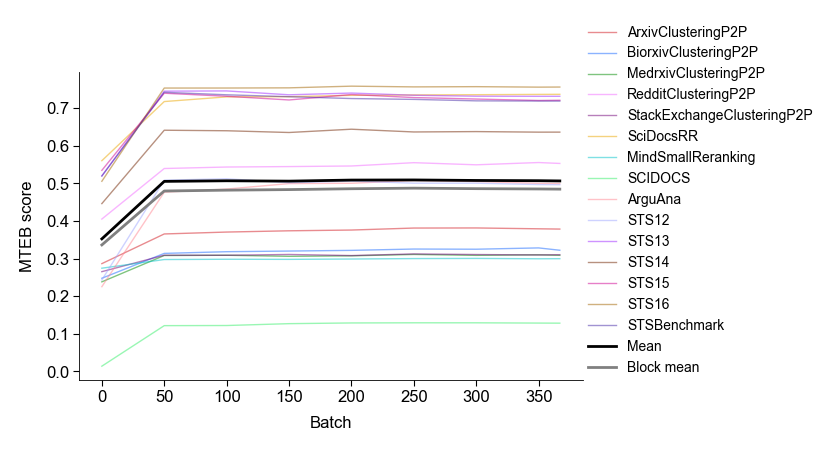

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)

# load
## mpnet crops
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results = pd.read_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches",
    engine="pyarrow",
)

df_training_eval_results.set_index("batch", inplace=True)

# calculate block means
df_block_mean = pd.DataFrame()
df_block_mean["clustering"] = df_training_eval_results[
    [
        "ArxivClusteringP2P",
        "BiorxivClusteringP2P",
        "MedrxivClusteringP2P",
        "RedditClusteringP2P",
        "StackExchangeClusteringP2P",
    ]
].mean(axis=1)

df_block_mean["reranking"] = df_training_eval_results[
    ["SciDocsRR", "MindSmallReranking"]
].mean(axis=1)
df_block_mean["retrieval"] = df_training_eval_results[
    ["SCIDOCS", "ArguAna"]
].mean(axis=1)
df_block_mean["sts"] = df_training_eval_results[
    ["STS15", "STS16", "STSBenchmark"]
].mean(axis=1)

# create palette
palette = glasbey.create_palette(
    palette_size=len(df_training_eval_results.columns),
    lightness_bounds=(20, 75),
    chroma_bounds=(50, 90),
)


for i, elem in enumerate(df_training_eval_results.columns):
    ax.plot(
        df_training_eval_results.index,
        df_training_eval_results[elem],
        label=elem,
        c=palette[i],
        alpha=0.5,
    )
    # ax.text(
    #     df_training_eval_results.index[-1] + 0.1,
    #     df_training_eval_results[elem].iloc[-1],
    #     f"{df_training_eval_results[elem].iloc[-1]:.1f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )

ax.plot(
    df_training_eval_results.index,
    df_training_eval_results.mean(axis=1),
    label="Mean",
    c="black",
    lw=1,
)
# ax.text(
#     df_training_eval_results.index[-1] + 0.1,
#     df_training_eval_results.mean(axis=1).iloc[-1],
#     f"{df_training_eval_results.mean(axis=1).iloc[-1]:.1f}",
#     fontsize=5,
#     va="center",
#     ha="left",
# )

ax.plot(
    df_block_mean.index,
    df_block_mean.mean(axis=1),
    label="Block mean",
    c="grey",
    lw=1,
)

ax.legend(loc=(1, 0))
# ax.set_ylim(0.3, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("MTEB score")

fig.savefig(figures_path / "mteb_scores_MPNet_crops_batches_train_iclr_v1.png")

#### Eval every 10 batches

In [ ]:
model_name = "MPNet"
model_path = "microsoft/mpnet-base"

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# wrap model
wrapped_model = FineTunedHFModelWrapper(model, tokenizer)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 180 ms, sys: 113 ms, total: 294 ms
Wall time: 3.23 s


In [ ]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# saving path mteb
saving_path = (
    Path("embeddings_" + model_name.lower())
    / Path("updated_dataset")
    / Path("mteb_benchmark")
    / Path("new_format")
)
mteb_save_path = variables_path / saving_path
(mteb_save_path).mkdir(exist_ok=True)


# training
losses, df_training_eval_results = train_loop(
    wrapped_model,
    training_loader,
    device,
    eval_train_data=None, #iclr2024.abstract[labels_iclr != "unlabeled"].to_list(),
    eval_train_labels=None, #labels_iclr[labels_iclr != "unlabeled"],
    eval_every_epochs=False,
    eval_every_batches=10,
    eval_function=MTEBEval,
    pooler=mean_pool,
    mteb_saving_path=mteb_save_path,
    mteb_tasks=mteb_tasks,
    n_epochs=1,
)

# Save results as parquet
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_mteb_batches_v2", losses)
df_training_eval_results.to_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

  0%|          | 0/368 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Clustering

- ArxivClusteringP2P, p2p

- BiorxivClusteringP2P, p2p

- MedrxivClusteringP2P, p2p

- RedditClusteringP2P, p2p

- StackExchangeClusteringP2P, p2p

Reranking

- SciDocsRR, s2s

- MindSmallReranking, s2s

Retrieval

- SCIDOCS, s2p

- ArguAna, s2p

STS

- STS12, s2s

- STS13, s2s

- STS14, s2s

- STS15, s2s

- STS16, s2s

- STSBenchmark, s2s

##### Merge results

In [ ]:
batches_1 = np.arange(0, 400, 50)
batches_2 = np.arange(0, 120, 10)
last_batch = np.array([367])

all_batches = np.hstack((np.union1d(batches_1, batches_2), last_batch))
print(all_batches)

[  0  10  20  30  40  50  60  70  80  90 100 110 150 200 250 300 350 367]


In [ ]:
import os
import json


def load_mteb_results(directory):
    results = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    data = json.load(f)

                # Create a key based on the relative path
                relative_path = os.path.relpath(file_path, directory)
                key = os.path.splitext(relative_path)[
                    0
                ]  # Remove the .json extension
                results[key] = data

    return results

In [ ]:
def create_mteb_dict(original_json_dict):
    clean_dict = dict()
    for key in np.sort(list(original_json_dict.keys())):
        task = key.split("/")[-1]
        if "scores" in original_json_dict[key].keys():
            # pretrained mpnet
            score_mpnet = original_json_dict[key]["scores"]["test"][0][
                "main_score"
            ]
            clean_dict[task] = score_mpnet

        else:
            continue

    return clean_dict

In [ ]:
final_dict_results = defaultdict(list)

for batch in all_batches:
    final_dict_results["batch"].append(batch)

    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("mteb_benchmark")
        / Path("new_format")
    )
    root_directory = (
        variables_path / saving_path / f"results_epoch_0_batch_{batch}"
    )
    json_results_dict = load_mteb_results(root_directory)

    # transform
    mteb_results_dict = create_mteb_dict(json_results_dict)

    # append
    [final_dict_results[k].append(v) for k, v in mteb_results_dict.items()]


df_training_eval_results = pd.DataFrame(final_dict_results)

In [ ]:
df_training_eval_results

,batch,ArguAna,ArxivClusteringP2P,BiorxivClusteringP2P,MedrxivClusteringP2P,MindSmallReranking,RedditClusteringP2P,SCIDOCS,STS12,STS13,STS14,STS15,STS16,STSBenchmark,SciDocsRR,StackExchangeClusteringP2P
0,0,0.22550,0.286805,0.247922,0.238383,0.274675,0.405401,0.01415,0.243431,0.520162,0.446454,0.534895,0.505863,0.519878,0.560579,0.265462
1,10,0.26140,0.318198,0.282860,0.258624,0.280395,0.443804,0.02072,0.239287,0.546729,0.459267,0.525042,0.529872,0.543161,0.588079,0.277583
2,20,0.37117,0.364071,0.331347,0.298475,0.300186,0.492956,0.05335,0.269957,0.589645,0.500454,0.510676,0.605632,0.611643,0.626583,0.303922
3,30,0.44731,0.362579,0.322819,0.312544,0.296389,0.513832,0.10083,0.419878,0.704948,0.602115,0.665623,0.704864,0.706322,0.699604,0.307470
4,40,0.47056,0.361869,0.311688,0.312765,0.298347,0.532951,0.12007,0.496665,0.741651,0.637952,0.729790,0.745516,0.738614,0.712471,0.305911
5,50,0.47872,0.364901,0.315637,0.313393,0.297758,0.538351,0.12368,0.515515,0.744016,0.643029,0.735652,0.751302,0.743193,0.722179,0.309289
6,60,0.47465,0.371534,0.326483,0.311341,0.296084,0.536404,0.12126,0.511566,0.745379,0.638575,0.726518,0.752243,0.738001,0.726834,0.307270
7,70,0.47752,0.373153,0.325685,0.312915,0.295156,0.543178,0.12274,0.511637,0.749409,0.640792,0.730530,0.758662,0.738497,0.726324,0.308146
8,80,0.48461,0.364271,0.322668,0.308182,0.297375,0.541959,0.12513,0.521489,0.754751,0.651448,0.746694,0.764512,0.744506,0.728565,0.308180
9,90,0.48831,0.370887,0.324098,0.313450,0.294467,0.545709,0.12331,0.525614,0.756253,0.652269,0.743513,0.763252,0.744922,0.733977,0.305661


In [ ]:
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results.to_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

#### Plot

In [ ]:
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 8
# mpl.rcParams["axes.titlesize"] = 6

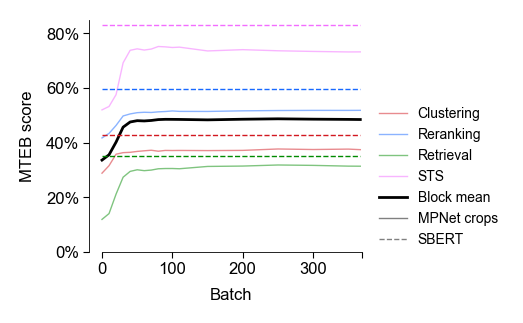

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2.5, 1.5), dpi=200, layout="constrained")

# load
## mpnet crops
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results = pd.read_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    engine="pyarrow",
)

df_training_eval_results.set_index("batch", inplace=True)

# calculate block means
df_block_mean = pd.DataFrame()
df_block_mean["clustering"] = df_training_eval_results[
    [
        "ArxivClusteringP2P",
        "BiorxivClusteringP2P",
        "MedrxivClusteringP2P",
        "RedditClusteringP2P",
        "StackExchangeClusteringP2P",
    ]
].mean(axis=1)

df_block_mean["reranking"] = df_training_eval_results[
    ["SciDocsRR", "MindSmallReranking"]
].mean(axis=1)
df_block_mean["retrieval"] = df_training_eval_results[
    ["SCIDOCS", "ArguAna"]
].mean(axis=1)
df_block_mean["sts"] = df_training_eval_results[
    ["STS15", "STS16", "STSBenchmark"]
].mean(axis=1)

# create palette
palette = glasbey.create_palette(
    palette_size=len(df_training_eval_results.columns),
    lightness_bounds=(20, 75),
    chroma_bounds=(50, 90),
)


for i, elem in enumerate(df_block_mean.columns):
    ax.plot(
        df_block_mean.index,
        df_block_mean[elem],
        label=[elem.upper() if elem == "sts" else elem.capitalize()],
        c=palette[i],
        alpha=0.5,
    )

# ax.plot(
#     df_training_eval_results.index,
#     df_training_eval_results.mean(axis=1),
#     label="Mean",
#     c="black",
#     lw=1,
# )


ax.plot(
    df_block_mean.index,
    df_block_mean.mean(axis=1),
    label="Block mean",
    c="k",
    lw=1,
)
# ax.text(
#     df_block_mean.index[-1],
#     df_block_mean.mean(axis=1).iloc[-1] - 0.009,
#     f"MPNet Crops: {df_block_mean.mean(axis=1).iloc[-1]:.1%}",
#     # fontsize=5,
#     va="top",
#     ha="right",
# )
# ax.scatter(0, df_block_mean.mean(axis=1).iloc[0], c="k", s=5)
# ax.text(
#     14,
#     df_block_mean.mean(axis=1).iloc[0],
#     f"MPNet base",
#     # fontsize=5,
#     va="center",
#     ha="left",
# )
# SBERT
# ax.hlines(0.552, 0, df_block_mean.index[-1], color="k", linestyles="--")

# ax.text(
#     df_block_mean.index[-1],
#     0.552 + 0.005,
#     f"SBERT: 55.2%",
#     # fontsize=5,
#     va="bottom",
#     ha="right",
# )


ax.hlines(0.428, 0, df_block_mean.index[-1], color=palette[0], linestyles="--")
ax.hlines(0.598, 0, df_block_mean.index[-1], color=palette[1], linestyles="--")
ax.hlines(0.351, 0, df_block_mean.index[-1], color=palette[2], linestyles="--")
ax.hlines(0.830, 0, df_block_mean.index[-1], color=palette[3], linestyles="--")
ax.plot([], [], color="grey", linestyle="-", label="MPNet crops")
ax.plot([], [], color="grey", linestyle="--", label="SBERT")

ax.legend(loc=(1, 0))
ax.set_ylim(0, 0.85)
# ax.set_yticks([0, 0.20, 0.40, 0.60, 0.80, 0.85])

ax.set_xticks([0, 100, 200, 300, 370])
ax.set_xticklabels([0, 100, 200, 300, ""])
ax.set_xlabel("Batch")
ax.set_ylabel("MTEB score")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# ax.set_yticklabels([0, 20, 40, 60, 80, ""])
ax.spines.bottom.set_bounds(0, 370)

# fig.savefig(figures_path / "mteb_scores_MPNet_crops_batches_train_iclr_v8.png")

In [ ]:
np.round((df_block_mean.loc[100] - df_block_mean.loc[0]) * 100, 1)

clustering     8.3
reranking      9.9
retrieval     18.6
sts           22.8
dtype: float64

In [ ]:
np.round((df_block_mean.iloc[-1] - df_block_mean.loc[0]) * 100, 1)

clustering     8.6
reranking     10.1
retrieval     19.4
sts           21.2
dtype: float64

In [ ]:
np.round((df_block_mean.iloc[-1] - df_block_mean.loc[0]) * 100, 1).mean()

14.825

In [ ]:
2 / 10 + 3 / 25

0.32

# More tasks

In [ ]:
# retrieval
ArguAna
ClimateFEVER
CQADupstackAndroidRetrieval
CQADupstackEnglishRetrieval
CQADupstackGamingRetrieval
CQADupstackGisRetrieval
CQADupstackMathematicaRetrieval
CQADupstackPhysicsRetrieval
CQADupstackProgrammersRetrieval
CQADupstackStatsRetrieval
CQADupstackTexRetrieval
CQADupstackUnixRetrieval
CQADupstackWebmastersRetrieval
CQADupstackWordpressRetrieval
DBPedia
FEVER
FiQA2018
HotpotQA
MSMARCO
MSMARCOv2

QuoraRetrieval
SCIDOCS
SciFact
Touche2020
TRECCOVID

# reranking
AskUbuntuDupQuestions
MindSmallReranking
SciDocsRR
StackOverflowDupQuestions

In [ ]:
new_tasks= [
    "AskUbuntuDupQuestions", # reranking
    "NFCorpus", # retrieval, ordered by relevance
    "NQ",
    "TRECCOVID",
    "SciFact",
    
]

### Fine-tuned MPNet (crops)

In [ ]:
model_name = "MPNet"
model_path = "microsoft/mpnet-base"

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# wrap model
wrapped_model = FineTunedHFModelWrapper(model, tokenizer)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 109 ms, sys: 8.99 ms, total: 118 ms
Wall time: 454 ms


In [ ]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# saving path mteb
saving_path = (
    Path("embeddings_" + model_name.lower())
    / Path("updated_dataset")
    / Path("mteb_benchmark")
    / Path("new_format")
)
mteb_save_path = variables_path / saving_path
(mteb_save_path).mkdir(exist_ok=True)


# training
losses, df_training_eval_results = train_loop(
    wrapped_model,
    training_loader,
    device,
    eval_train_data=None, #iclr2024.abstract[labels_iclr != "unlabeled"].to_list(),
    eval_train_labels=None, #labels_iclr[labels_iclr != "unlabeled"],
    eval_every_epochs=False,
    eval_every_batches=50,
    eval_function=MTEBEval,
    pooler=mean_pool,
    mteb_saving_path=mteb_save_path,
    mteb_tasks=new_tasks,
    n_epochs=1,
)

# Save results as parquet
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_mteb_batches_new_tasks", losses)
df_training_eval_results.to_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_new_tasks",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

  0%|          | 0/368 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Clustering

- ArxivClusteringP2P, p2p

- BiorxivClusteringP2P, p2p

- MedrxivClusteringP2P, p2p

- RedditClusteringP2P, p2p

- StackExchangeClusteringP2P, p2p

Reranking

- SciDocsRR, s2s

- MindSmallReranking, s2s

Retrieval

- SCIDOCS, s2p

- ArguAna, s2p

STS

- STS12, s2s

- STS13, s2s

- STS14, s2s

- STS15, s2s

- STS16, s2s

- STSBenchmark, s2s

Clustering: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:47<00:00, 34.75s/it]
Repo card metadata block was not found. Setting CardData to empty.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/802 [00:00<?, ?it/s]

Using the latest cached version of the dataset since mteb/arguana couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'corpus' at /gpfs01/berens/user/rgonzalesmarquez/.cache/huggingface/datasets/mteb___arguana/corpus/0.0.0/c22ab2a51041ffd869aaddef7af8d8215647e41a (last modified on Fri Aug  2 16:39:03 2024).


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/272 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Clustering

- ArxivClusteringP2P, p2p

- BiorxivClusteringP2P, p2p

- MedrxivClusteringP2P, p2p

- RedditClusteringP2P, p2p

- StackExchangeClusteringP2P, p2p

Reranking

- SciDocsRR, s2s

- MindSmallReranking, s2s

Retrieval

- SCIDOCS, s2p

- ArguAna, s2p

STS

- STS12, s2s

- STS13, s2s

- STS14, s2s

- STS15, s2s

- STS16, s2s

- STSBenchmark, s2s

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

#### Plot

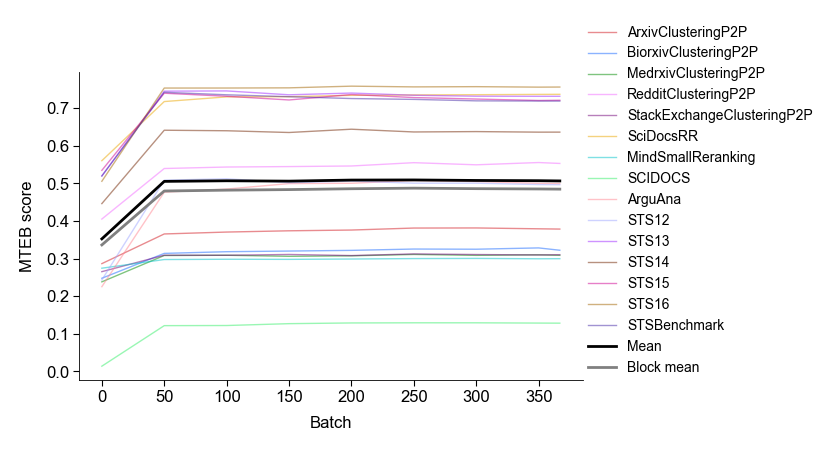

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)

# load
## mpnet crops
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results = pd.read_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches",
    engine="pyarrow",
)

df_training_eval_results.set_index("batch", inplace=True)

# calculate block means
df_block_mean = pd.DataFrame()
df_block_mean["clustering"] = df_training_eval_results[
    [
        "ArxivClusteringP2P",
        "BiorxivClusteringP2P",
        "MedrxivClusteringP2P",
        "RedditClusteringP2P",
        "StackExchangeClusteringP2P",
    ]
].mean(axis=1)

df_block_mean["reranking"] = df_training_eval_results[
    ["SciDocsRR", "MindSmallReranking"]
].mean(axis=1)
df_block_mean["retrieval"] = df_training_eval_results[
    ["SCIDOCS", "ArguAna"]
].mean(axis=1)
df_block_mean["sts"] = df_training_eval_results[
    ["STS15", "STS16", "STSBenchmark"]
].mean(axis=1)

# create palette
palette = glasbey.create_palette(
    palette_size=len(df_training_eval_results.columns),
    lightness_bounds=(20, 75),
    chroma_bounds=(50, 90),
)


for i, elem in enumerate(df_training_eval_results.columns):
    ax.plot(
        df_training_eval_results.index,
        df_training_eval_results[elem],
        label=elem,
        c=palette[i],
        alpha=0.5,
    )
    # ax.text(
    #     df_training_eval_results.index[-1] + 0.1,
    #     df_training_eval_results[elem].iloc[-1],
    #     f"{df_training_eval_results[elem].iloc[-1]:.1f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )

ax.plot(
    df_training_eval_results.index,
    df_training_eval_results.mean(axis=1),
    label="Mean",
    c="black",
    lw=1,
)
# ax.text(
#     df_training_eval_results.index[-1] + 0.1,
#     df_training_eval_results.mean(axis=1).iloc[-1],
#     f"{df_training_eval_results.mean(axis=1).iloc[-1]:.1f}",
#     fontsize=5,
#     va="center",
#     ha="left",
# )

ax.plot(
    df_block_mean.index,
    df_block_mean.mean(axis=1),
    label="Block mean",
    c="grey",
    lw=1,
)

ax.legend(loc=(1, 0))
# ax.set_ylim(0.3, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("MTEB score")

fig.savefig(figures_path / "mteb_scores_MPNet_crops_batches_train_iclr_v1.png")

#### Eval every 10 batches

In [ ]:
model_name = "MPNet"
model_path = "microsoft/mpnet-base"

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# wrap model
wrapped_model = FineTunedHFModelWrapper(model, tokenizer)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 180 ms, sys: 113 ms, total: 294 ms
Wall time: 3.23 s


In [ ]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# saving path mteb
saving_path = (
    Path("embeddings_" + model_name.lower())
    / Path("updated_dataset")
    / Path("mteb_benchmark")
    / Path("new_format")
)
mteb_save_path = variables_path / saving_path
(mteb_save_path).mkdir(exist_ok=True)


# training
losses, df_training_eval_results = train_loop(
    wrapped_model,
    training_loader,
    device,
    eval_train_data=None, #iclr2024.abstract[labels_iclr != "unlabeled"].to_list(),
    eval_train_labels=None, #labels_iclr[labels_iclr != "unlabeled"],
    eval_every_epochs=False,
    eval_every_batches=10,
    eval_function=MTEBEval,
    pooler=mean_pool,
    mteb_saving_path=mteb_save_path,
    mteb_tasks=mteb_tasks,
    n_epochs=1,
)

# Save results as parquet
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_mteb_batches_v2", losses)
df_training_eval_results.to_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

  0%|          | 0/368 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Clustering

- ArxivClusteringP2P, p2p

- BiorxivClusteringP2P, p2p

- MedrxivClusteringP2P, p2p

- RedditClusteringP2P, p2p

- StackExchangeClusteringP2P, p2p

Reranking

- SciDocsRR, s2s

- MindSmallReranking, s2s

Retrieval

- SCIDOCS, s2p

- ArguAna, s2p

STS

- STS12, s2s

- STS13, s2s

- STS14, s2s

- STS15, s2s

- STS16, s2s

- STSBenchmark, s2s

##### Merge results

In [ ]:
batches_1 = np.arange(0, 400, 50)
batches_2 = np.arange(0, 120, 10)
last_batch = np.array([367])

all_batches = np.hstack((np.union1d(batches_1, batches_2), last_batch))
print(all_batches)

[  0  10  20  30  40  50  60  70  80  90 100 110 150 200 250 300 350 367]


In [ ]:
import os
import json


def load_mteb_results(directory):
    results = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    data = json.load(f)

                # Create a key based on the relative path
                relative_path = os.path.relpath(file_path, directory)
                key = os.path.splitext(relative_path)[
                    0
                ]  # Remove the .json extension
                results[key] = data

    return results

In [ ]:
def create_mteb_dict(original_json_dict):
    clean_dict = dict()
    for key in np.sort(list(original_json_dict.keys())):
        task = key.split("/")[-1]
        if "scores" in original_json_dict[key].keys():
            # pretrained mpnet
            score_mpnet = original_json_dict[key]["scores"]["test"][0][
                "main_score"
            ]
            clean_dict[task] = score_mpnet

        else:
            continue

    return clean_dict

In [ ]:
final_dict_results = defaultdict(list)

for batch in all_batches:
    final_dict_results["batch"].append(batch)

    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("mteb_benchmark")
        / Path("new_format")
    )
    root_directory = (
        variables_path / saving_path / f"results_epoch_0_batch_{batch}"
    )
    json_results_dict = load_mteb_results(root_directory)

    # transform
    mteb_results_dict = create_mteb_dict(json_results_dict)

    # append
    [final_dict_results[k].append(v) for k, v in mteb_results_dict.items()]


df_training_eval_results = pd.DataFrame(final_dict_results)

In [ ]:
df_training_eval_results

,batch,ArguAna,ArxivClusteringP2P,BiorxivClusteringP2P,MedrxivClusteringP2P,MindSmallReranking,RedditClusteringP2P,SCIDOCS,STS12,STS13,STS14,STS15,STS16,STSBenchmark,SciDocsRR,StackExchangeClusteringP2P
0,0,0.22550,0.286805,0.247922,0.238383,0.274675,0.405401,0.01415,0.243431,0.520162,0.446454,0.534895,0.505863,0.519878,0.560579,0.265462
1,10,0.26140,0.318198,0.282860,0.258624,0.280395,0.443804,0.02072,0.239287,0.546729,0.459267,0.525042,0.529872,0.543161,0.588079,0.277583
2,20,0.37117,0.364071,0.331347,0.298475,0.300186,0.492956,0.05335,0.269957,0.589645,0.500454,0.510676,0.605632,0.611643,0.626583,0.303922
3,30,0.44731,0.362579,0.322819,0.312544,0.296389,0.513832,0.10083,0.419878,0.704948,0.602115,0.665623,0.704864,0.706322,0.699604,0.307470
4,40,0.47056,0.361869,0.311688,0.312765,0.298347,0.532951,0.12007,0.496665,0.741651,0.637952,0.729790,0.745516,0.738614,0.712471,0.305911
5,50,0.47872,0.364901,0.315637,0.313393,0.297758,0.538351,0.12368,0.515515,0.744016,0.643029,0.735652,0.751302,0.743193,0.722179,0.309289
6,60,0.47465,0.371534,0.326483,0.311341,0.296084,0.536404,0.12126,0.511566,0.745379,0.638575,0.726518,0.752243,0.738001,0.726834,0.307270
7,70,0.47752,0.373153,0.325685,0.312915,0.295156,0.543178,0.12274,0.511637,0.749409,0.640792,0.730530,0.758662,0.738497,0.726324,0.308146
8,80,0.48461,0.364271,0.322668,0.308182,0.297375,0.541959,0.12513,0.521489,0.754751,0.651448,0.746694,0.764512,0.744506,0.728565,0.308180
9,90,0.48831,0.370887,0.324098,0.313450,0.294467,0.545709,0.12331,0.525614,0.756253,0.652269,0.743513,0.763252,0.744922,0.733977,0.305661


In [ ]:
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results.to_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

#### Plot

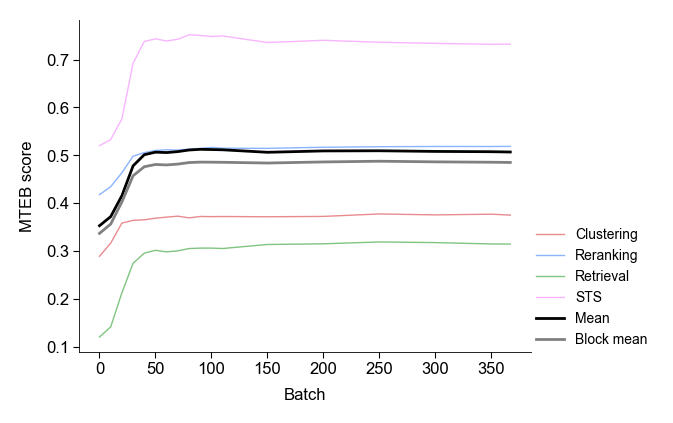

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

# load
## mpnet crops
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results = pd.read_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    engine="pyarrow",
)

df_training_eval_results.set_index("batch", inplace=True)

# calculate block means
df_block_mean = pd.DataFrame()
df_block_mean["clustering"] = df_training_eval_results[
    [
        "ArxivClusteringP2P",
        "BiorxivClusteringP2P",
        "MedrxivClusteringP2P",
        "RedditClusteringP2P",
        "StackExchangeClusteringP2P",
    ]
].mean(axis=1)

df_block_mean["reranking"] = df_training_eval_results[
    ["SciDocsRR", "MindSmallReranking"]
].mean(axis=1)
df_block_mean["retrieval"] = df_training_eval_results[
    ["SCIDOCS", "ArguAna"]
].mean(axis=1)
df_block_mean["sts"] = df_training_eval_results[
    ["STS15", "STS16", "STSBenchmark"]
].mean(axis=1)

# create palette
palette = glasbey.create_palette(
    palette_size=len(df_training_eval_results.columns),
    lightness_bounds=(20, 75),
    chroma_bounds=(50, 90),
)


for i, elem in enumerate(df_block_mean.columns):
    ax.plot(
        df_block_mean.index,
        df_block_mean[elem],
        label=[elem.upper() if elem == "sts" else elem.capitalize()],
        c=palette[i],
        alpha=0.5,
    )
    # ax.text(
    #     df_training_eval_results.index[-1] + 0.1,
    #     df_training_eval_results[elem].iloc[-1],
    #     f"{df_training_eval_results[elem].iloc[-1]:.1f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )

ax.plot(
    df_training_eval_results.index,
    df_training_eval_results.mean(axis=1),
    label="Mean",
    c="black",
    lw=1,
)
# ax.text(
#     df_training_eval_results.index[-1] + 0.1,
#     df_training_eval_results.mean(axis=1).iloc[-1],
#     f"{df_training_eval_results.mean(axis=1).iloc[-1]:.1f}",
#     fontsize=5,
#     va="center",
#     ha="left",
# )

ax.plot(
    df_block_mean.index,
    df_block_mean.mean(axis=1),
    label="Block mean",
    c="grey",
    lw=1,
)

ax.legend(loc=(1, 0))
# ax.set_ylim(0.3, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("MTEB score")

fig.savefig(figures_path / "mteb_scores_MPNet_crops_batches_train_iclr_v3.png")

In [ ]:
np.round((df_block_mean.loc[100] - df_block_mean.loc[0]) * 100, 1)

clustering     8.3
reranking      9.9
retrieval     18.6
sts           22.8
dtype: float64

In [ ]:
2 / 10 + 3 / 25

0.32